<a href="https://colab.research.google.com/github/raven-gith/machinelearning1/blob/main/11.%20Chapter%2011/chapter_11_training_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 11: Training Deep Neural Networks

Notebook ini mereproduksi dan menjelaskan isi Bab 11 dari buku _Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow_ oleh Aurélien Géron.

## 📘 Ringkasan Materi:

Bab ini fokus pada **strategi pelatihan Deep Neural Networks (DNN)** agar model bisa konvergen lebih cepat dan menghindari overfitting.

### Materi utama:
1. **Weight Initialization** (He, Xavier)
2. **Activation Functions** (ReLU, ELU, SELU)
3. **Batch Normalization**
4. **Gradient Clipping**
5. **Callbacks: EarlyStopping, ReduceLROnPlateau**
6. **Optimizers: Adam, RMSprop, Nadam**


In [1]:

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# Contoh arsitektur DNN dengan beberapa strategi
model = keras.models.Sequential([
    layers.Dense(100, activation="relu", kernel_initializer="he_normal", input_shape=[28*28]),
    layers.Dense(100, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

In [2]:

# Dengan BatchNormalization
model_bn = keras.models.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(300, kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dense(100, kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dense(10, activation="softmax")
])
model_bn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,210 (1.02 MB)

 Trainable params: 267,410 (1.02 MB)

 Non-trainable params: 800 (3.12 KB)

In [3]:

# Dataset MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

# Compile
model_bn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="nadam",
                 metrics=["accuracy"])

# Callback dan training
early_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_cb = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

history = model_bn.fit(X_train, y_train, epochs=20,
                       validation_split=0.1,
                       callbacks=[early_cb, lr_cb])


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8899 - loss: 0.3755 - val_accuracy: 0.9713 - val_loss: 0.0968 - learning_rate: 0.0010
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9668 - loss: 0.1048 - val_accuracy: 0.9777 - val_loss: 0.0787 - learning_rate: 0.0010
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9772 - loss: 0.0733 - val_accuracy: 0.9800 - val_loss: 0.0767 - learning_rate: 0.0010
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9825 - loss: 0.0533 - val_accuracy: 0.9823 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9855 - loss: 0.0461 - val_accuracy: 0.9837 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9872 - loss: 0.0380 - val_accuracy: 0.9812 - val_loss: 0.0708 - learning_rate: 0.0010
Epoch 7/20
1688/168

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9776 - loss: 0.0757
Test accuracy: 0.9805999994277954


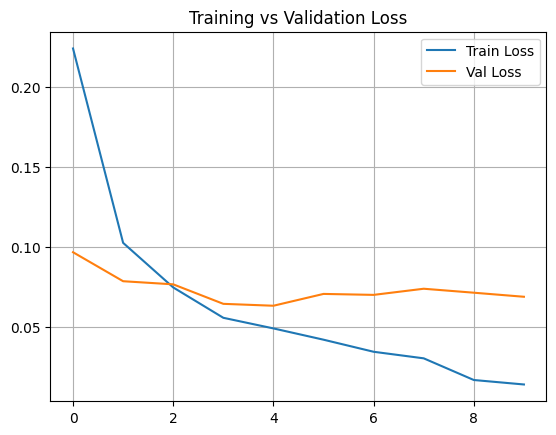

In [4]:

import matplotlib.pyplot as plt

test_loss, test_acc = model_bn.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Plot learning curve
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.show()
